In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/jgb-omr


In [3]:
import torch
import torch.nn as nn
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import re
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [4]:
df = pd.read_csv('pairs.csv')

df

,Filename,Annotations
0,관악영산회상-가락덜이_daegeum_37.png,청무\n-\n노라
1,관악영산회상-가락덜이_daegeum_58.png,청무\n-\n노
2,관악영산회상-가락덜이_daegeum_73.png,청임\n-\n같은음표 나니나
3,관악영산회상-가락덜이_haegeum_19.png,중 ㅅ
4,관악영산회상-가락덜이_haegeum_48.png,중 ㅅ
...,...,...
889,여민락_haegeum_814.png,"배남\n-\n-, 배임 더름표"
890,여민락_haegeum_849.png,임 ^\n-\n남
891,여민락_haegeum_878.png,"태\n-\n-, 황 더름표"
892,여민락_haegeum_891.png,중\n-\n태


In [65]:

class RandomBoundaryDrop:
  def __init__(self, amount=3) -> None:
    self.amount = amount
  
  def __call__(self, img):
    rand_num = random.random()
    boundary_amount = random.randint(1, self.amount)
    if rand_num < 0.25:
      return img[:, :-boundary_amount] 
    elif rand_num < 0.5:
      return img[:, boundary_amount:]
    elif rand_num < 0.75:
      return img[:-boundary_amount, :]
    else:
      return img[boundary_amount:, :]

class Tokenizer:
  def __init__(self, entire_strs) -> None:
    self.entire_strs = entire_strs
    self.vocab = self.get_vocab()
    self.tok2idx = {tok: idx for idx, tok in enumerate(self.vocab)}

  def get_vocab(self):
    vocabs = {'\n', ','}
    for label in self.entire_strs:
      words = re.split(' |\n', label)
      words = [word.replace(',', '') for word in words]
      words = [word for word in words if word != '']
      vocabs.update(words)
    list_vocabs = sorted(list(vocabs))
    return ['<pad>', '<start>', '<end>'] + list_vocabs

  def __call__(self, label):
    label = label.replace('\n', ' \n ')
    label = label.replace(',', ' , ')
    words = label.split(' ')
    words = [word for word in words if word != '']
    words = ['<start>'] + words + ['<end>']
    return [self.tok2idx[word] for word in words]
  
  def decode(self, labels):
    return ' '.join([self.vocab[idx] for idx in labels])

class Dataset:
  def __init__(self, csv_path, img_dir) -> None:
    self.df = pd.read_csv(csv_path)
    self.img_dir = Path(img_dir)
    self.transform = transforms.Compose([
    RandomBoundaryDrop(4),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: 1-x),
    # transforms.Resize((160, 140)),
    ])
    self.tokenizer = Tokenizer(self.df['Annotations'].values.tolist())

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img = cv2.imread( str(self.img_dir / row['Filename']))
    annotations = row['Annotations']
    img = self.transform(img)
    return img, self.tokenizer(annotations)
  

def pad_collate(raw_batch):
  # raw batch is a list of tuples (img, annotation)
  # img is torch tensor with shape (1, H, W)
  # pad to same width by adding 0s to the left and right
  # pad to same height by adding 0s to the top and bottom

  # find max width and height
  max_width = max([img.shape[2] for img, _ in raw_batch])
  max_height = max([img.shape[1] for img, _ in raw_batch])

  img_batch = torch.zeros((len(raw_batch), 1, max_height, max_width))
  for i, (img, _) in enumerate(raw_batch):
    h, w = img.shape[1], img.shape[2]
    left_pad = (max_width - w) // 2
    top_pad = (max_height - h) // 2
    img_batch[i, :, top_pad:top_pad+h, left_pad:left_pad+w] = img

  
  max_token_length = max([len(label) for _, label in raw_batch])
  label_batch = torch.zeros((len(raw_batch), max_token_length), dtype=torch.long)
  for i, (_, label) in enumerate(raw_batch):
    label_batch[i, :len(label)] = torch.tensor(label)
  

  return img_batch, label_batch[:, :-1], label_batch[:, 1:]

  
dataset = Dataset('pairs.csv', 'jeongganbo-png/unique-char-pngs/')
img, label = dataset[30]
# img
# print(label)
# plt.imshow(img.squeeze(), cmap='gray')
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

batch = next(iter(data_loader)) 
batch

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [133]:
import re


entire_strs = dataset.df['Annotations'].values.tolist()
tokenizer = Tokenizer(entire_strs)

self = tokenizer
label = dataset[30][1]

def call(self, label):
  label = label.replace('\n', ' \n ')
  label = label.replace(',', ' , ')
  words = label.split(' ')
  words = [word for word in words if word != '']
  words = ['<start>'] + words + ['<end>']
  return [self.tok2idx[word] for word in words]

for i in range(len(dataset)):
  _, label = dataset[i]
  print(call(tokenizer, label))

[1, 90, 3, 7, 3, 35, 2]
[1, 90, 3, 7, 3, 32, 2]
[1, 91, 3, 7, 3, 24, 28, 2]
[1, 87, 22, 2]
[1, 87, 22, 2]
[1, 59, 3, 7, 3, 113, 2]
[1, 7, 5, 3, 7, 3, 87, 2]
[1, 88, 17, 3, 7, 6, 93, 2]
[1, 91, 52, 3, 89, 17, 2]
[1, 7, 3, 93, 34, 2]
[1, 93, 29, 2]
[1, 7, 3, 93, 6, 30, 2]
[1, 82, 17, 3, 44, 2]
[1, 30, 3, 82, 2]
[1, 88, 3, 7, 6, 93, 2]
[1, 89, 3, 7, 6, 91, 2]
[1, 30, 2]
[1, 30, 50, 3, 82, 60, 2]
[1, 82, 9, 3, 95, 2]
[1, 93, 29, 5, 2]
[1, 7, 3, 7, 6, 32, 3, 90, 41, 52, 2]
[1, 93, 42, 2]
[1, 95, 6, 92, 3, 7, 6, 35, 3, 43, 2]
[1, 92, 3, 7, 6, 35, 3, 43, 2]
[1, 95, 6, 92, 3, 7, 6, 35, 3, 43, 2]
[1, 95, 3, 7, 6, 44, 3, 59, 5, 2]
[1, 95, 44, 2]
[1, 7, 3, 7, 6, 92, 3, 93, 6, 95, 2]
[1, 93, 21, 3, 7, 6, 43, 3, 91, 6, 90, 2]
[1, 92, 3, 7, 5, 3, 93, 28, 2]
[1, 82, 34, 3, 7, 6, 32, 3, 59, 41, 2]
[1, 93, 21, 3, 7, 6, 92, 3, 39, 2]
[1, 91, 6, 90, 3, 7, 3, 7, 6, 44, 2]
[1, 91, 5, 3, 90, 3, 7, 16, 2]
[1, 82, 17, 3, 87, 3, 7, 2]
[1, 113, 6, 87, 3, 7, 4, 3, 113, 34, 2]
[1, 113, 3, 7, 3, 98, 2]
[1, 82, 17,

In [111]:
label

'배중 ㅅ'

In [103]:
label.split('\n', ' ')

TypeError: 'str' object cannot be interpreted as an integer

In [85]:
torch.max(img), torch.min(img)

(tensor(0.8810), tensor(0.0040))

In [22]:
img

tensor([[[ 32,  30,  34],
         [ 32,  30,  34],
         [ 32,  30,  34],
         ...,
         [ 32,  30,  34],
         [ 32,  30,  34],
         [ 32,  30,  34]],

        [[ 32,  30,  34],
         [ 70,  70,  71],
         [135, 134, 136],
         ...,
         [135, 134, 136],
         [135, 134, 136],
         [ 86,  86,  87]],

        [[ 30,  30,  33],
         [167, 166, 168],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [167, 166, 168]],

        ...,

        [[ 32,  30,  34],
         [167, 166, 168],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [167, 166, 168]],

        [[ 30,  30,  33],
         [167, 166, 168],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [173, 173, 176]],

        [[ 32,  30,  34],
         [151, 150, 152],
         [232, 232, 233],
         ...,
         [232, 232, 233],
        

In [60]:

class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    # self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.GELU()

  def forward(self, x):
    x = self.conv(x)
    # x = self.bn(x)
    x = self.relu(x)
    return x


class ContextAttention(nn.Module):
  def __init__(self, size, num_head):
    super(ContextAttention, self).__init__()
    self.attention_net = nn.Linear(size, size)
    self.num_head = num_head

    if size % num_head != 0:
        raise ValueError("size must be dividable by num_head", size, num_head)
    self.head_size = int(size/num_head)
    self.context_vector = torch.nn.Parameter(torch.Tensor(num_head, self.head_size, 1))
    nn.init.uniform_(self.context_vector, a=-1, b=1)

  def get_attention(self, x):
    attention = self.attention_net(x)
    attention_tanh = torch.tanh(attention)
    attention_split = torch.stack(attention_tanh.split(split_size=self.head_size, dim=2), dim=0)
    similarity = torch.bmm(attention_split.view(self.num_head, -1, self.head_size), self.context_vector)
    similarity = similarity.view(self.num_head, x.shape[0], -1).permute(1,2,0)
    return similarity

  def forward(self, x):
    attention = self.attention_net(x)
    attention_tanh = torch.tanh(attention)
    if self.head_size != 1:
      attention_split = torch.stack(attention_tanh.split(split_size=self.head_size, dim=2), dim=0)
      similarity = torch.bmm(attention_split.view(self.num_head, -1, self.head_size), self.context_vector)
      similarity = similarity.view(self.num_head, x.shape[0], -1).permute(1,2,0)
      similarity[x.sum(-1)==0] = -1e10 # mask out zero padded_ones
      softmax_weight = torch.softmax(similarity, dim=1)

      x_split = torch.stack(x.split(split_size=self.head_size, dim=2), dim=2)
      weighted_x = x_split * softmax_weight.unsqueeze(-1).repeat(1,1,1, x_split.shape[-1])
      attention = weighted_x.view(x_split.shape[0], x_split.shape[1], x.shape[-1])
    else:
      softmax_weight = torch.softmax(attention, dim=1)
      attention = softmax_weight * x

    sum_attention = torch.sum(attention, dim=1)
    return sum_attention

class OMRModel(nn.Module):
  def __init__(self, hidden_size, vocab_size, num_gru_layers=2):
    super().__init__()

    self.layers = nn.Sequential(
          ConvBlock(1, hidden_size//4, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size//4, hidden_size//4, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size//4, hidden_size//2, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size//2, hidden_size//2, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size//2, hidden_size, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size, hidden_size, 3, 1, 1),
    )
    
    self.context_attention = ContextAttention(hidden_size, 4)
    self.cont2hidden = nn.Linear(hidden_size, hidden_size*num_gru_layers)
    self.cnn_gru = nn.GRU(hidden_size, hidden_size//2, 1, batch_first=True, dropout = 0.2, bidirectional=True)

    self.kv = nn.Linear(hidden_size, hidden_size*2)
    self.q = nn.Linear(hidden_size, hidden_size)
    self.num_head = 4

    self.emb = nn.Embedding(vocab_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, num_gru_layers, batch_first=True, dropout = 0.2)
    self.mlp = nn.Sequential(
        nn.Linear(hidden_size, hidden_size * 4),
        nn.GELU(),
        nn.Linear(hidden_size * 4, hidden_size),
    )

    self.proj = nn.Linear(hidden_size*2, vocab_size)

  def run_img_cnn(self, x):
    x = self.layers(x)
    x = x.permute(0, 2, 3, 1)
    x = x.reshape(x.shape[0], -1, x.shape[-1])
    x = x.contiguous()
    x, _ = self.cnn_gru(x)

    context_vector = self.context_attention(x)
    context_vector = self.cont2hidden(context_vector.relu())
    context_vector = context_vector.reshape(x.shape[0], -1, context_vector.shape[-1]//2).permute(1,0,2)
    context_vector = context_vector.contiguous()

    return x, context_vector

  
  def forward(self, x, y):
    x, context_vector = self.run_img_cnn(x)
    y = self.emb(y)
    gru_out, _ = self.gru(y, context_vector)
    kv = self.kv(x)
    k, v = torch.split(kv, kv.shape[-1]//2, dim=-1)
    q = self.q(gru_out)
    attention_score = torch.bmm(q, k.permute(0,2,1))
    attention_score = torch.softmax(attention_score, dim=-1)

    attention = torch.bmm(attention_score, v)
    attention = self.mlp(attention)

    cat_out = torch.cat([gru_out, attention], dim=-1)
    logit = self.proj(cat_out)

    return logit

  @torch.inference_mode()  
  def inference(self, x):
    assert x.shape[0] == 1 # batch size must be 1

    x, last_hidden = self.run_img_cnn(x)
    kv = self.kv(x)
    k, v = torch.split(kv, kv.shape[-1]//2, dim=-1)

    y = torch.ones((1, 1), dtype=torch.long).to(x.device)
    outputs = []
    for _ in range(100):
      y = self.emb(y)
      gru_out, last_hidden = self.gru(y, last_hidden)
      q = self.q(gru_out)
      attention_score = torch.bmm(q, k.permute(0,2,1))
      attention_score = torch.softmax(attention_score, dim=-1)

      attention = torch.bmm(attention_score, v)
      attention = self.mlp(attention)

      cat_out = torch.cat([gru_out, attention], dim=-1)
      logit = self.proj(cat_out)
      y = torch.argmax(logit, dim=-1)
      if y == 2:
        break
      outputs.append(y.item())
    return outputs


# model = OMRModel(128, vocab_size=len(tokenizer.vocab))
batch = next(iter(data_loader))
img, label, shifted_label = batch
out = model(img, label)
out.shape

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [57]:
class Trainer:
  def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, device, model_name='nmt_model'):
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    
    self.model.to(device)
    
    self.grad_clip = 1.0
    self.best_valid_accuracy = 0
    self.device = device
    
    self.training_loss = []
    self.validation_loss = []
    self.validation_acc = []
    self.model_name = model_name

  def save_model(self, path):
    torch.save({'model':self.model.state_dict(), 'optim':self.optimizer.state_dict()}, path)
    
  def train_by_num_epoch(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        loss_value = self._train_by_single_batch(batch)
        self.training_loss.append(loss_value)
      self.model.eval()
      validation_loss, validation_acc = self.validate()
      self.validation_loss.append(validation_loss)
      self.validation_acc.append(validation_acc)
      
      if validation_acc > self.best_valid_accuracy:
        print(f"Saving the model with best validation accuracy: Epoch {epoch+1}, Acc: {validation_acc:.4f} ")
        self.save_model(f'{self.model_name}_best.pt')
      else:
        self.save_model(f'{self.model_name}_last.pt')
      self.best_valid_accuracy = max(validation_acc, self.best_valid_accuracy)

      
  def _train_by_single_batch(self, batch):
    '''
    This method updates self.model's parameter with a given batch
    
    batch (tuple): (batch_of_input_text, batch_of_label)
    
    You have to use variables below:
    
    self.model (Translator/torch.nn.Module): A neural network model
    self.optimizer (torch.optim.adam.Adam): Adam optimizer that optimizes model's parameter
    self.loss_fn (function): function for calculating BCE loss for a given prediction and target
    self.device (str): 'cuda' or 'cpu'

    output: loss (float): Mean binary cross entropy value for every sample in the training batch
    The model's parameters, optimizer's steps has to be updated inside this method
    '''
    
    src, tgt_i, tgt_o = batch
    pred = self.model(src.to(self.device), tgt_i.to(self.device))
    loss = self.loss_fn(pred, tgt_o)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
    self.optimizer.step()
    self.optimizer.zero_grad()
    
    return loss.item()

    
  def validate(self, external_loader=None):
    '''
    This method calculates accuracy and loss for given data loader.
    It can be used for validation step, or to get test set result
    
    input:
      data_loader: If there is no data_loader given, use self.valid_loader as default.
      
    output: 
      validation_loss (float): Mean Binary Cross Entropy value for every sample in validation set
      validation_accuracy (float): Mean Accuracy value for every sample in validation set
    '''
    
    ### Don't change this part
    if external_loader and isinstance(external_loader, DataLoader):
      loader = external_loader
      print('An arbitrary loader is used instead of Validation loader')
    else:
      loader = self.valid_loader
      
    self.model.eval()
    
    '''
    Write your code from here, using loader, self.model, self.loss_fn.
    '''
    validation_loss = 0
    validation_acc = 0
    num_total_tokens = 0
    with torch.no_grad():
      for batch in tqdm(loader, leave=False):
        
        src, tgt_i, tgt_o = batch
        pred = self.model(src.to(self.device), tgt_i.to(self.device))
        loss = self.loss_fn(pred, tgt_o)
        num_tokens = (tgt_o != 0).sum().item()
        validation_loss += loss.item() * num_tokens
        num_total_tokens += num_tokens
        
        acc = torch.argmax(pred, dim=-1) == tgt_o.to(self.device)
        acc = acc[tgt_o != 0].sum()
        validation_acc += acc.item()
        
    return validation_loss / num_total_tokens, validation_acc / num_total_tokens

def get_nll_loss(predicted_prob_distribution, indices_of_correct_token, eps=1e-10, ignore_index=0):
  '''
  for PackedSequence, the input is 2D tensor
  
  predicted_prob_distribution has a shape of [num_entire_tokens_in_the_batch x vocab_size]
  indices_of_correct_token has a shape of [num_entire_tokens_in_the_batch]
  '''

  if predicted_prob_distribution.ndim == 3:
    predicted_prob_distribution = predicted_prob_distribution.reshape(-1, predicted_prob_distribution.shape[-1])
    indices_of_correct_token = indices_of_correct_token.reshape(-1)


  prob_of_correct_next_word = torch.log_softmax(predicted_prob_distribution, dim=-1)[torch.arange(len(predicted_prob_distribution)), indices_of_correct_token]
  filtered_prob = prob_of_correct_next_word[indices_of_correct_token != ignore_index]
  loss = -filtered_prob
  return loss.mean()

  
model = OMRModel(128, vocab_size=len(dataset.tokenizer.vocab))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, 
                                                               [int(len(dataset)*0.8), 
                                                                int(len(dataset)*0.1), 
                                                                len(dataset) - int(len(dataset)*0.8)  - int(len(dataset)*0.1)] )

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=pad_collate)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=pad_collate)

trainer = Trainer(model, torch.optim.Adam(model.parameters(), lr=1e-3), get_nll_loss, train_loader, valid_loader, 'cuda')

In [59]:
trainer.train_by_num_epoch(30)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 2, Acc: 0.8534 


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 8, Acc: 0.8643 


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 15, Acc: 0.8705 


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 25, Acc: 0.8721 


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [66]:


model = OMRModel(128, vocab_size=len(dataset.tokenizer.vocab))
model.load_state_dict(torch.load('nmt_model_best.pt')['model'])
tokenizer = dataset.tokenizer


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


'임 ^ \n - , 노 \n 중 )'

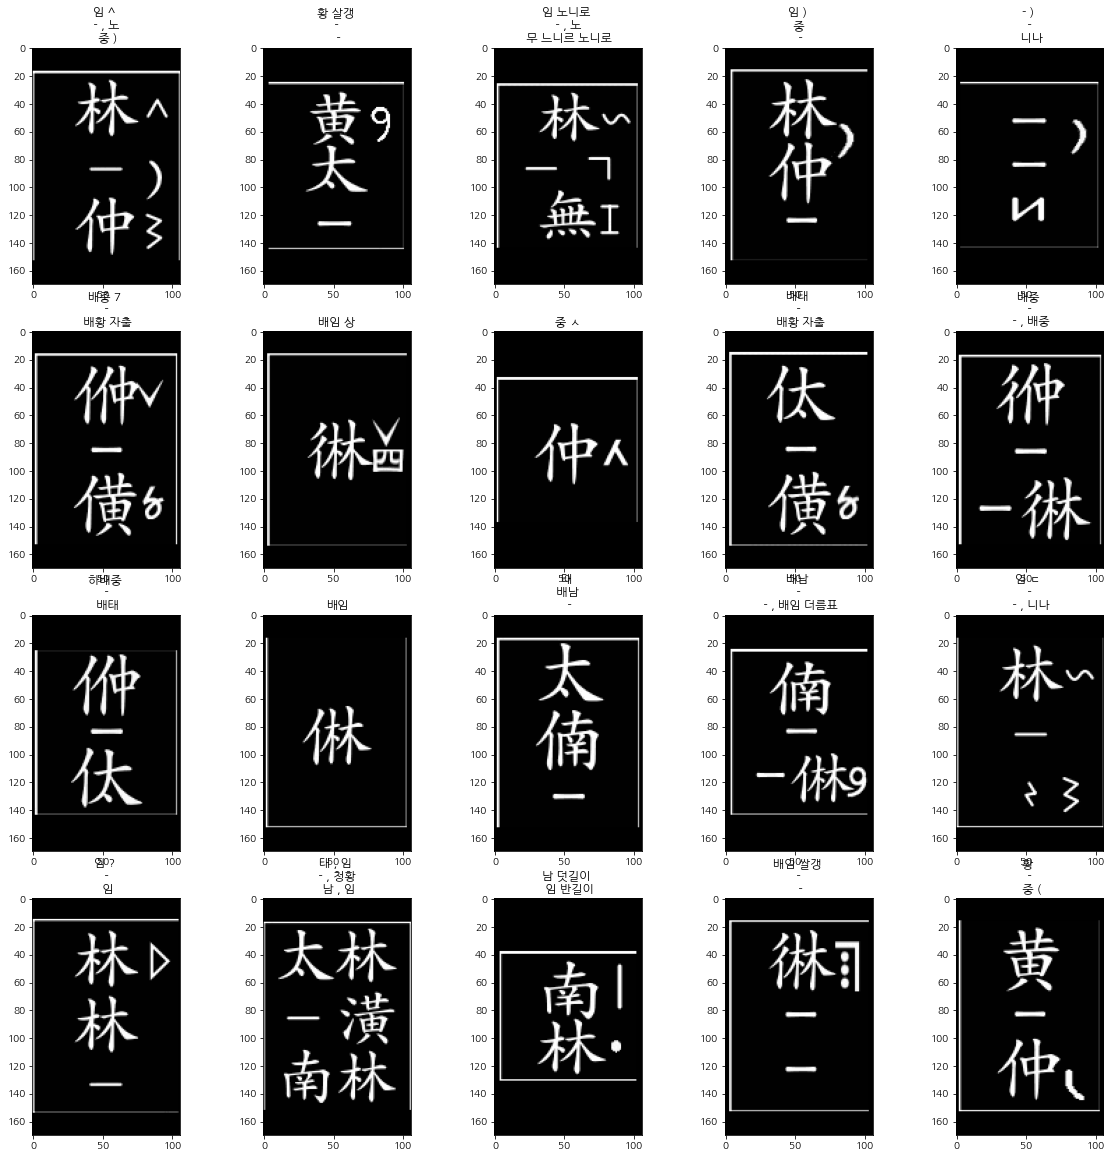

In [86]:
import koreanize_matplotlib

test_img, test_label, _ = next(iter(test_loader))


plt.figure(figsize=(20, 20))
for idx in range(20):
  plt.subplot(4, 5, idx+1)
  plt.imshow(test_img[idx].squeeze().cpu().numpy(), cmap='gray')
  output = tokenizer.decode(model.inference(test_img[idx:idx+1]))
  plt.title(output)
# test_img = test_img[idx:idx+1]
# plt.imshow(test_img.squeeze().cpu().numpy(), cmap='gray')
# tokenizer.decode(model.inference(test_img))

In [161]:
out[1].shape

torch.Size([32, 10, 15])

In [149]:
len(tokenizer.vocab)

114